In [1]:
import rasterio
from rasterio.features import rasterize
import geopandas as gpd
import numpy as np
from shapely.geometry import mapping
import matplotlib.pyplot as plt

from scipy.ndimage import median_filter
from scipy.ndimage import uniform_filter
from scipy.ndimage import gaussian_filter
from scipy.ndimage import minimum_filter


import startinpy

dt = startinpy.DT()

## Separating trees from DSM. 

Two tasks:
1. Mask out trees
2. Fill with ground values




# Current

### Create a canopy DSM

1. Load DSM
2. Load Trees (gpkg, will be raster in final?)
3. Create tree mask by rasterizing trees (same extent as dsm)
4. Create canopy dsm by masking trees (fill with 0 or nan, UMEP wants 0?)
5. export canopy dsm

Create building and topography dsm:
5. Load building mask
6. Load osm/bag buildings
7. remove buildings and trees from DSM
8. smooth the edges to get rid of outliers (minimum filter)
7. interpolate using startinpy (laplace/NNI?)
8. Smooth results
8. reintroduce buildings to interpolated dsm
9. save


Then run umep with both (just buildings and topography and buildings and trees, with veg function)


In [169]:
# Read DSM
with rasterio.open('../data/clean_data/solar/12011952/12011952_p_6_2022_06_02_dsm.tif') as src:
    dsm = src.read(1)
    dsm_meta = src.meta.copy()
    dsm_crs = src.crs

# Read canopy poly
trees = gpd.read_file('/Users/lbeuster/Documents/TU Delft/Projects/lidR/results/25EZ1_21.gpkg')
trees_crs = trees.crs

# Check and reproject if necessary
if trees_crs != dsm_crs:
    trees = trees.to_crs(dsm_crs)

trees.geometry = trees.buffer(1.5)

# Rasterize tree polygons (same size as dsm so it works with UMEP)
tree_mask = rasterize(
    ((mapping(geom), 1) for geom in trees.geometry),
    out_shape=dsm.shape,
    transform=dsm_meta['transform'],
    fill=0,
    dtype='uint8'
)

# Create Canopy DSM
canopy_dsm = np.where(tree_mask == 1, dsm, np.nan)

# # Save Canopy DSM
# dsm_meta.update(dtype='float32', nodata=np.nan)
# with rasterio.open('canopy_dsm.tif', 'w', **dsm_meta) as dst:
#     dst.write(canopy_dsm, 1)

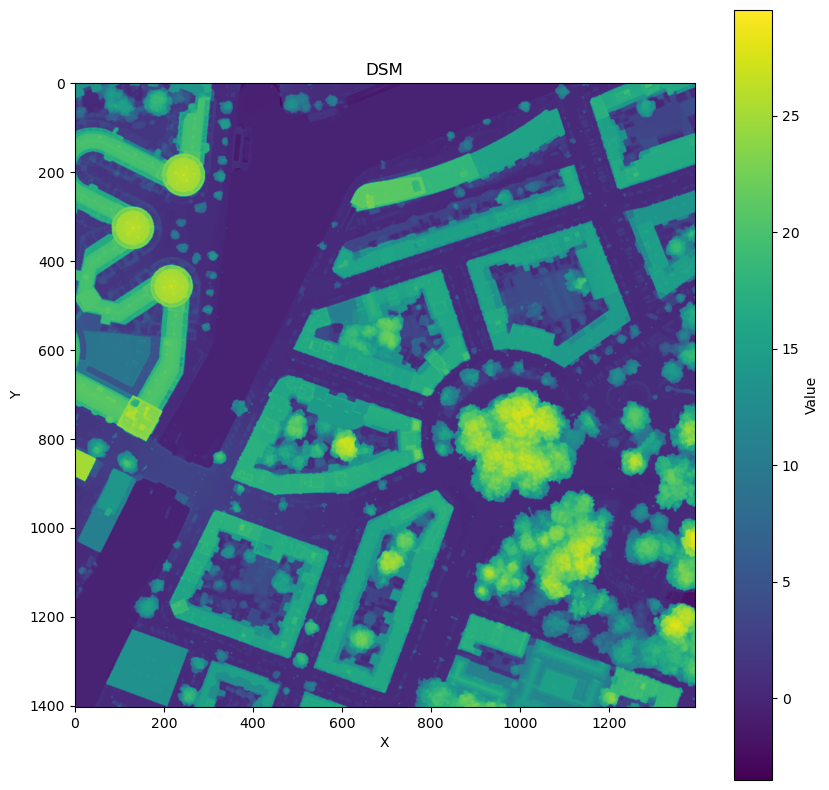

In [274]:
# Plot the combined raster
plt.figure(figsize=(10, 10))
plt.imshow(dsm, cmap='viridis')
plt.title('DSM')
plt.colorbar(label='Value')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

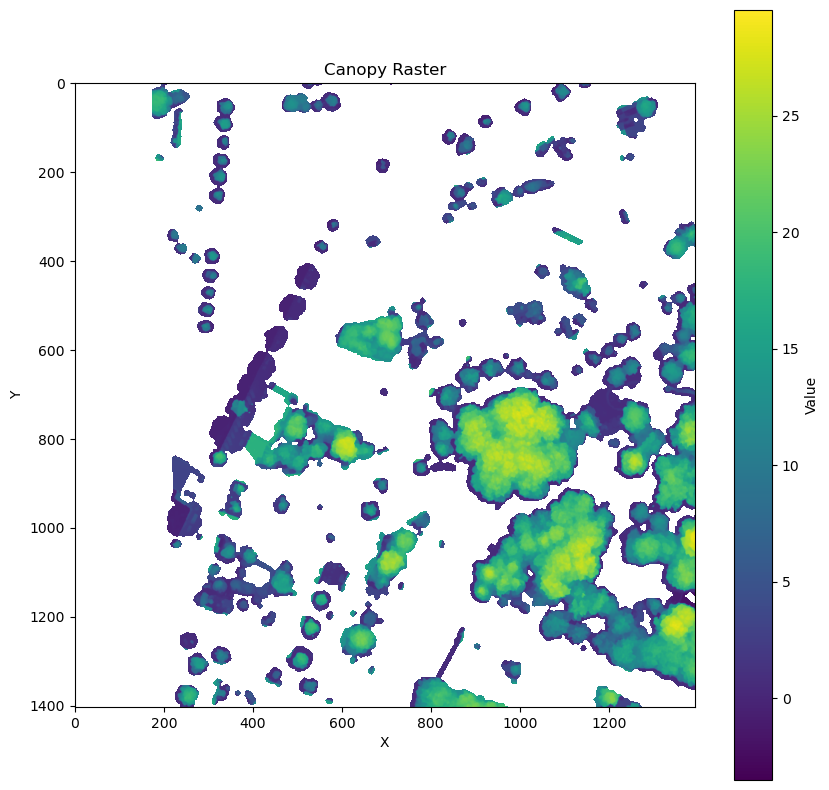

In [275]:
# Plot the combined raster
plt.figure(figsize=(10, 10))
plt.imshow(canopy_dsm, cmap='viridis')
plt.title('Canopy Raster')
plt.colorbar(label='Value')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

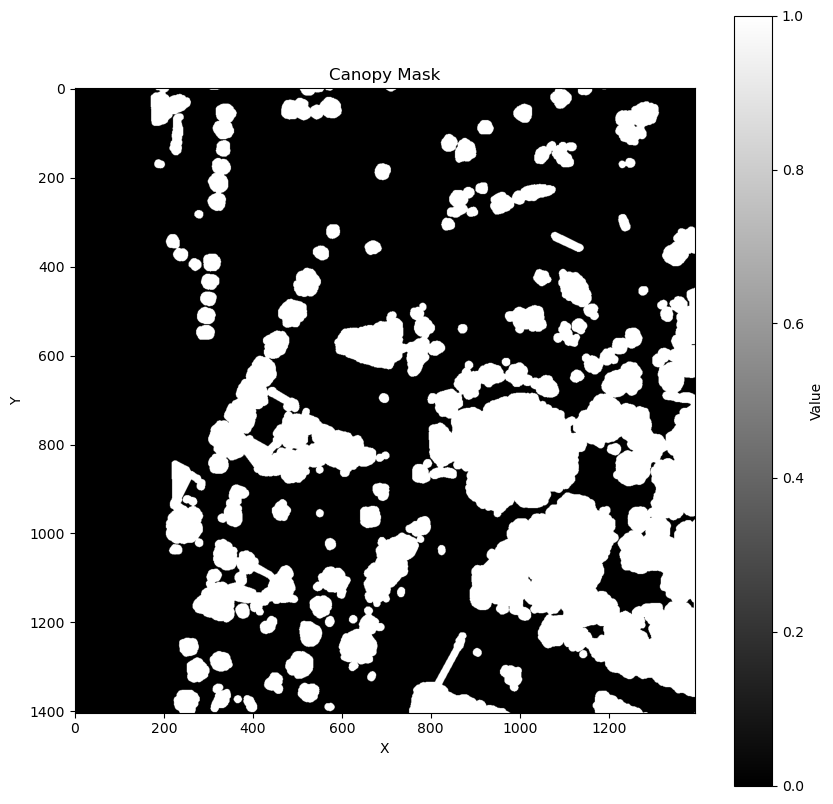

In [172]:
# Plot the combined raster
plt.figure(figsize=(10, 10))
plt.imshow(tree_mask, cmap='gray')
plt.title('Canopy Mask')
plt.colorbar(label='Value')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

Two options: Either combine masks first, then mask out (canopy and buildings) or mask separately. 

Need to also add the osm buildings. That'd make things a little easier when filtering the edges, hopefully. 

In [124]:
# Read DSM
with rasterio.open('../data/clean_data/solar/12011952/12011952_p_6_2022_06_02_mask.tif') as src:
    bldg_mask = src.read(1)
    bldg_mask_meta = src.meta.copy()
    transform = src.transform
    crs = src.crs
    dtype = src.dtypes[0]

### Adding OSM buildings

In [ ]:
# Read buildings poly
buildings = gpd.read_file('/Users/lbeuster/Documents/TU Delft/Projects/Land_Surface_Temperature/data/raw_data/3DBAG/Amsterdam_buildings.gpkg')
bldg_crs = buildings.crs

# Check and reproject if necessary
if bldg_crs != dsm_crs:
    buildings = buildings.to_crs(dsm_crs)

In [182]:
buildings.geometry = buildings.buffer(1.5)

# Rasterize building polygons (same size as dsm so it works with UMEP)
osm_bldg_mask = rasterize(
    ((mapping(geom), 1) for geom in buildings.geometry),
    out_shape=dsm.shape,
    transform=dsm_meta['transform'],
    fill=0,
    dtype='uint8'
)

In [ ]:
# Plot the original and filtered data for comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

# Original data
cax1 = ax1.imshow(osm_bldg_mask, cmap='viridis')
ax1.set_title('OSM Building Mask')
fig.colorbar(cax1, ax=ax1, orientation='vertical')

# Filtered data
cax2 = ax2.imshow(bldg_mask, cmap='viridis')
ax2.set_title('Solar API Building Mask')
fig.colorbar(cax2, ax=ax2, orientation='vertical')

plt.show()

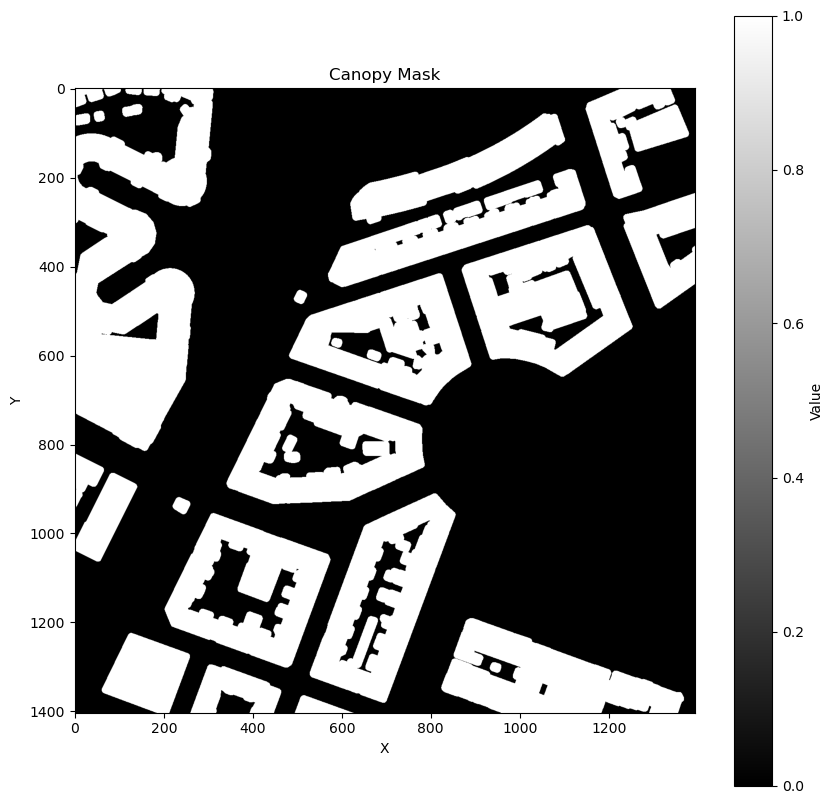

In [183]:
# Plot the combined raster
plt.figure(figsize=(10, 10))
plt.imshow(osm_bldg_mask, cmap='gray')
plt.title('OSM Building Mask')
plt.colorbar(label='Value')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

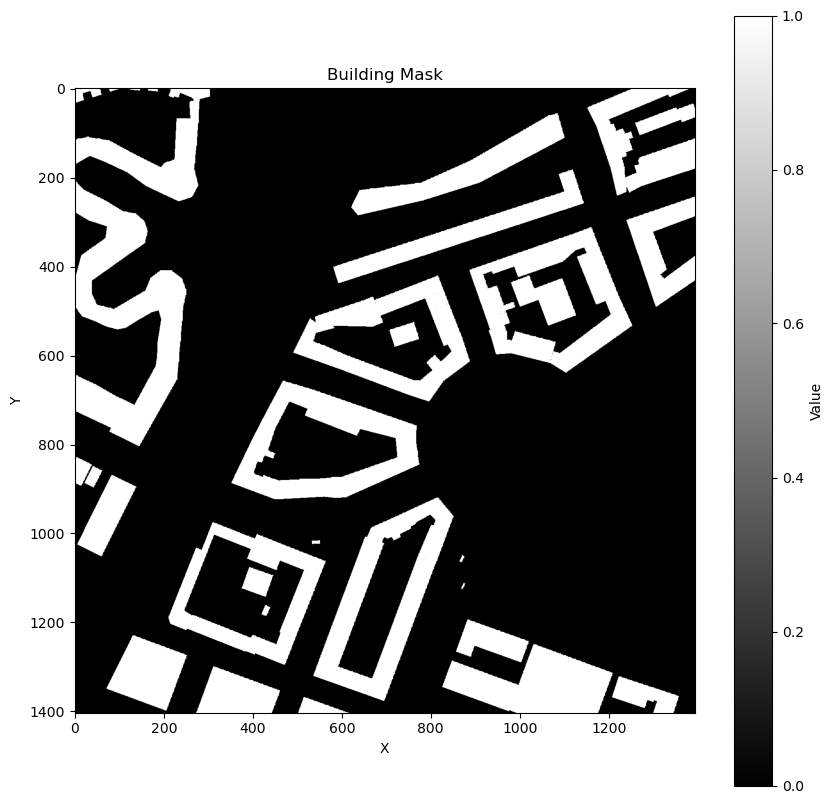

In [184]:
# Plot the combined raster
plt.figure(figsize=(10, 10))
plt.imshow(bldg_mask, cmap='gray')
plt.title('Building Mask')
plt.colorbar(label='Value')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [186]:
combined_building_mask = np.logical_or(bldg_mask, osm_bldg_mask).astype(np.uint8)
combined_mask = np.logical_or(tree_mask, combined_building_mask).astype(np.uint8)
combined_mask

## OLD:

# combined_mask = np.logical_or(tree_mask, bldg_mask).astype(np.uint8)
# combined_mask

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]], dtype=uint8)

In [187]:
dtm_raw = np.where(combined_mask == 0, dsm, np.nan)

dsm_meta.update(dtype='float32', nodata=np.nan)
with rasterio.open('../data/clean_data/canopydsm/dtm_raw.tif', 'w', **dsm_meta) as dst:
    dst.write(dtm_raw, 1)

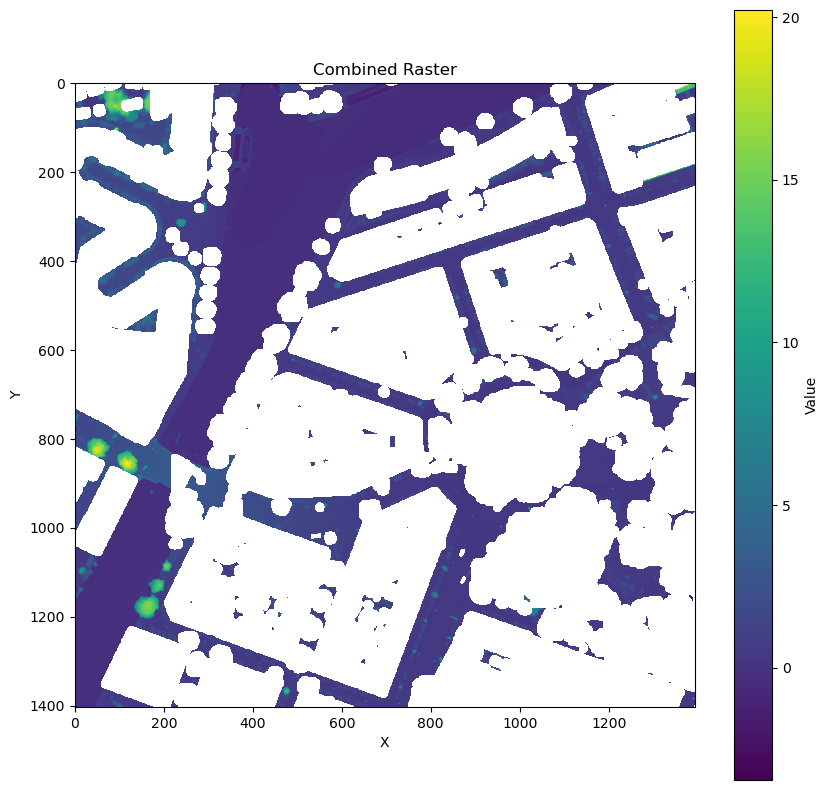

In [188]:
# Plot the combined raster
plt.figure(figsize=(10, 10))
plt.imshow(dtm_raw, cmap='viridis')
plt.title('Combined Raster')
plt.colorbar(label='Value')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

### Filters

TODO: add a function to the filters to fill nodata values (to clean up little gaps after interpolation)

TODO: ADD A PERCENTILE OUTLIER FILTER AS WELL (highest x percentile to nan)

In [102]:

# Function to apply a median filter to a raster dataset
def apply_median_filter(data, nodata_value, size=3):
    # Create a mask for nodata values
    mask = (data == nodata_value)
    
    # Apply the median filter only to valid data
    filtered_data = data.copy()
    filtered_data[~mask] = median_filter(data[~mask], size=size)
    
    return filtered_data


# Function to apply a mean filter to a raster dataset
def apply_mean_filter(data, nodata_value, size=3):
    # Create a mask for nodata values
    mask = (data == nodata_value)
    
    # Apply the mean filter only to valid data
    filtered_data = data.copy()
    filtered_data[~mask] = uniform_filter(data[~mask], size=size)
    
    return filtered_data

# Function to apply a Gaussian filter to a raster dataset
def apply_gaussian_filter(data, nodata_value, sigma=1):
    # Create a mask for nodata values
    mask = (data == nodata_value)
    
    # Apply the Gaussian filter only to valid data
    filtered_data = data.copy()
    filtered_data[~mask] = gaussian_filter(data[~mask], sigma=sigma)
    
    return filtered_data

# Function to apply a minimum filter to a raster dataset
def apply_minimum_filter(data, nodata_value, size=3):
    # Create a mask for nodata values
    mask = (data == nodata_value)
    
    # Apply the Gaussian filter only to valid data
    filtered_data = data.copy()
    filtered_data[~mask] = minimum_filter(data[~mask], size=size)
    
    return filtered_data

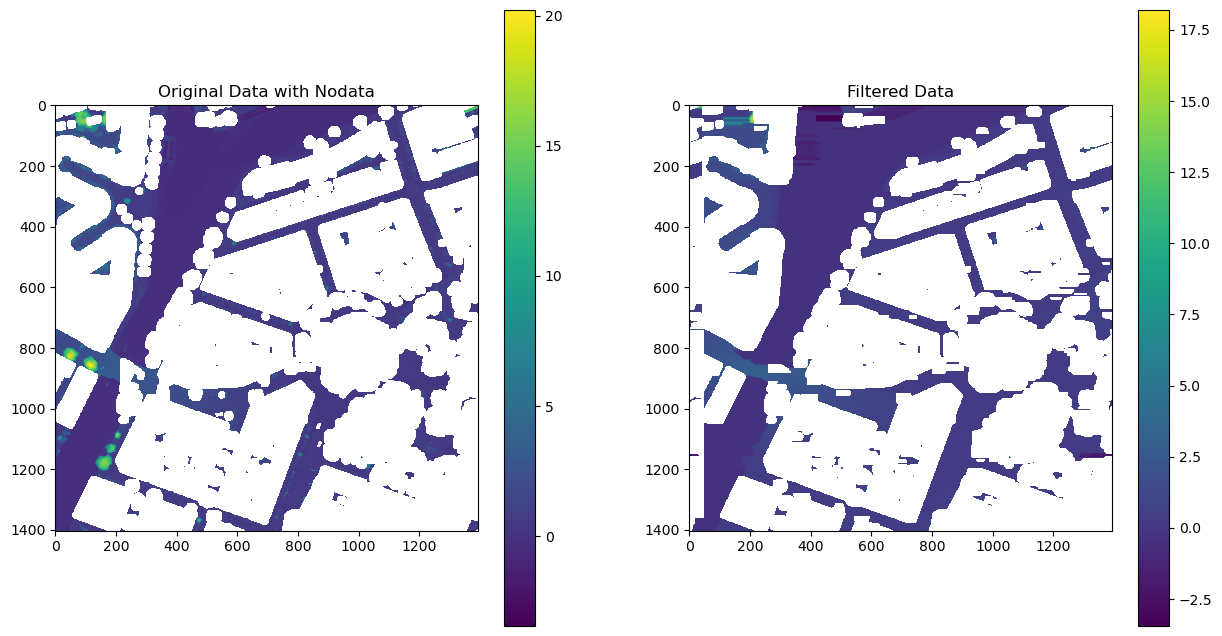

In [189]:
# # Apply median filter
# filtered_data = apply_median_filter(dtm_raw, np.nan, size=10)
# filtered_data = apply_median_filter(filtered_data, np.nan, size=10)

# Apply mean filter
# filtered_data = apply_mean_filter(dtm_raw, np.nan, size=10)


# # Apply Gaussian filter
# filtered_data = apply_gaussian_filter(data, np.nan, sigma=1)
# filtered_data = apply_median_filter(filtered_data, np.nan, size=10)

## Apply minimum filter
filtered_data = apply_minimum_filter(dtm_raw, np.nan, size=50)
filtered_data = apply_minimum_filter(filtered_data, np.nan, size=30)
filtered_data = apply_minimum_filter(filtered_data, np.nan, size=10)
# filtered_data = apply_median_filter(filtered_data, np.nan, size=10)


# Save the filtered raster
dsm_meta.update(dtype='float32', nodata=np.nan)
with rasterio.open('../data/clean_data/canopydsm/dtm_raw_filtered.tif', 'w', **dsm_meta) as dst:
    dst.write(filtered_data, 1)

# Plot the original and filtered data for comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

# Original data
cax1 = ax1.imshow(np.where(dtm_raw == np.nan, np.nan, dtm_raw), cmap='viridis')
ax1.set_title('Original Data with Nodata')
fig.colorbar(cax1, ax=ax1, orientation='vertical')

# Filtered data
cax2 = ax2.imshow(np.where(filtered_data == np.nan, np.nan, filtered_data), cmap='viridis')
ax2.set_title('Filtered Data')
fig.colorbar(cax2, ax=ax2, orientation='vertical')

plt.show()

### Interpolation using startinpy

In [244]:
with rasterio.open('../data/clean_data/canopydsm/dtm_raw_filtered.tif') as src:
    data = src.read(1)
    bldg_mask_meta = src.meta.copy()
    t = src.transform
    crs = src.crs
    nodata = src.nodata
    dtype = src.dtypes[0]
    # # Replace nodata values with np.nan for easier manipulation
    data = np.where(data == nodata, np.nan, data)
pts = []
coords = []
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        x = t[2] + (j * t[0]) + (t[0] / 2)
        y = t[5] + (i * t[4]) + (t[4] / 2)
        z = data[i][j]
        # Add all point coordinates. Laplace interpolation keeps existing values. 
        coords.append([x,y])
        if not np.isnan(z):
            pts.append([x, y, z])
            # print('data found')
dt = startinpy.DT()
dt.insert(pts, insertionstrategy="BBox")

interpolated = dt.interpolate({"method": "Laplace"}, coords)

# This only writes the DT ground truth and ignores the interpolation
# dt.write_ply("../data/clean_data/canopydsm/mydt_Laplace.ply")

### Old: Needed overhaul because interpolate doesn

# with rasterio.open('../data/clean_data/canopydsm/dtm_raw_filtered.tif') as src:
#     data = src.read(1)
#     bldg_mask_meta = src.meta.copy()
#     t = src.transform
#     crs = src.crs
#     nodata = src.nodata
#     dtype = src.dtypes[0]
#     # # Replace nodata values with np.nan for easier manipulation
#     data = np.where(data == nodata, np.nan, data)
# pts = []
# coords = []
# for i in range(data.shape[0]):
#     for j in range(data.shape[1]):
#         x = t[2] + (j * t[0]) + (t[0] / 2)
#         y = t[5] + (i * t[4]) + (t[4] / 2)
#         z = data[i][j]
#         if not np.isnan(z):
#             pts.append([x, y, z])
#             # print('data found')
#         else:
#             coords.append([x,y])
# dt = startinpy.DT()
# dt.insert(pts, insertionstrategy="BBox")
# dt.interpolate({"method": "Laplace"}, coords)

# dt.write_ply("../data/clean_data/canopydsm/mydt_Laplace.ply")

In [245]:
# Check for NaN values
nan_mask = np.isnan(interpolated)

print("Array:", interpolated)
print("NaN mask:", nan_mask)
print("Indices of NaN values:", np.where(nan_mask))
print("Number of NaN values:", np.sum(nan_mask))
print("Number of total values:", len(interpolated))

Array: [nan nan nan ... nan nan nan]
NaN mask: [ True  True  True ...  True  True  True]
Indices of NaN values: (array([      0,       1,       2, ..., 1955779, 1955780, 1955781]),)
Number of NaN values: 6428
Number of total values: 1955782


### Save to raster

In [248]:
# Path to your existing raster file
input_raster = '../data/clean_data/solar/12011952/12011952_p_6_2022_06_02_dsm.tif'

# Open the raster file
with rasterio.open(input_raster) as src:
    # Extract metadata
    width = src.width
    height = src.height
    crs = src.crs
    transform = src.transform
    nodata_value = src.nodata
    dtype = src.dtypes[0]

    # Calculate resolution
    resolution_x = transform[0]
    resolution_y = -transform[4]  # Typically negative in the geotransform

    # Calculate extent
    xmin = transform[2]
    ymax = transform[5]
    xmax = xmin + (width * resolution_x)
    ymin = ymax + (height * transform[4])  # Typically negative

    print("Width:", width)
    print("Height:", height)
    print("CRS:", crs)
    print("Transform:", transform)
    print("NoData Value:", nodata_value)
    print("Data Type:", dtype)
    print("Resolution (x, y):", (resolution_x, resolution_y))
    print("Extent (xmin, ymin, xmax, ymax):", (xmin, ymin, xmax, ymax))

Width: 1394
Height: 1403
CRS: EPSG:32631
Transform: | 0.25, 0.00, 627429.00|
| 0.00,-0.25, 5805065.75|
| 0.00, 0.00, 1.00|
NoData Value: None
Data Type: float32
Resolution (x, y): (0.25, 0.25)
Extent (xmin, ymin, xmax, ymax): (627429.0, 5804715.0, 627777.5, 5805065.75)


In [271]:
from rasterio.transform import from_origin

# Calculate the number of rows and columns
ncols = int((xmax - xmin) / resolution_x)
nrows = int((ymax - ymin) / resolution_y)

# print(ncols)
# print(nrows)

# Create an empty raster array
# raster_array = np.full((nrows, ncols), np.nan, dtype=np.float32)
raster_array = np.full((nrows, ncols), np.nan, dtype=np.float32)

# Ensure the points are in the correct structure (startinpy returns a flattened 1D array containing only the interpolated values for some reason)

# Combine the coordinates and values into a 2D array with shape (n, 3)
points = np.array([(x, y, val) for (x, y), val in zip(coords, interpolated)])
points


# Check if the array length is a multiple of 3
if points.size % 3 != 0:
    raise ValueError(f"Array size {points.size} is not a multiple of 3, cannot reshape.")
# Reshape the points array if it's flattened
if points.ndim == 1:
    points = points.reshape(-1, 3)

# In this example, points should be a 2D array with shape (n, 3)
print(f"Points shape: {points.shape}")

# Map the points to the raster grid
for point in points:
    if len(point) != 3:
        raise ValueError(f"Expected point to have 3 elements (x, y, value), but got {len(point)} elements.")
    x, y, value = point
    # Skip points with NaN values
    if np.isnan(value):
        continue
    
    col = int((x - xmin) / resolution_x)
    row = int((ymax - y) / resolution_y)
    
    # Ensure the indices are within bounds
    if 0 <= col < ncols and 0 <= row < nrows:
        raster_array[row, col] = value

# Define the transform (mapping from pixel coordinates to spatial coordinates)
transform = from_origin(xmin, ymax, resolution_x, resolution_y)

print(transform)

# Define the metadata for the new raster
meta = {
    'driver': 'GTiff',
    'dtype': dtype,
    'nodata': nodata_value,
    'width': width,
    'height': height,
    'count': 1,
    'crs': crs,
    'transform': transform
}

filtered_raster = apply_minimum_filter(raster_array, np.nan, size=40)
filtered_raster = apply_minimum_filter(filtered_raster, np.nan, size=20)
filtered_raster = apply_minimum_filter(filtered_raster, np.nan, size=10)

# Write the raster array to a new file
output_raster = '../data/clean_data/canopydsm/dsm_buildings.tif'
with rasterio.open(output_raster, 'w', **meta) as dst:
    dst.write(filtered_raster, 1)

print(f"Raster saved to {output_raster}")

### Old (was using only ground truth points, and couldn't handle nan):
# # Example array of points (x, y, value)
# points = dt.points
# points = points[1:]
# points = points [:-1]
# print(len(points))

# # Calculate the number of rows and columns
# ncols = int((xmax - xmin) / resolution_x)
# nrows = int((ymax - ymin) / resolution_y)

# # print(ncols)
# # print(nrows)

# # Create an empty raster array
# # raster_array = np.full((nrows, ncols), np.nan, dtype=np.float32)
# raster_array = np.full((nrows, ncols), np.nan, dtype=np.float32)

# # Map the points to the raster grid
# for point in points:
#     x, y, value = point
#     col = int((x - xmin) / resolution_x)
#     row = int((ymax - y) / resolution_y)
#     raster_array[row, col] = value

# # Define the transform (mapping from pixel coordinates to spatial coordinates)
# transform = from_origin(xmin, ymax, resolution_x, resolution_y)

# print(transform)

# # Define the metadata for the new raster
# meta = {
#     'driver': 'GTiff',
#     'dtype': dtype,
#     'nodata': nodata_value,
#     'width': width,
#     'height': height,
#     'count': 1,
#     'crs': crs,
#     'transform': transform
# }

# # Write the raster array to a new file
# output_raster = '../data/clean_data/canopydsm/dsm_buildings.tif'
# with rasterio.open(output_raster, 'w', **meta) as dst:
#     dst.write(raster_array, 1)

# print(f"Raster saved to {output_raster}")

Points shape: (1955782, 3)
| 0.25, 0.00, 627429.00|
| 0.00,-0.25, 5805065.75|
| 0.00, 0.00, 1.00|
Raster saved to ../data/clean_data/canopydsm/dsm_buildings.tif


#### Combined raster without additional filter

Still a few spots visible that aren't smooth

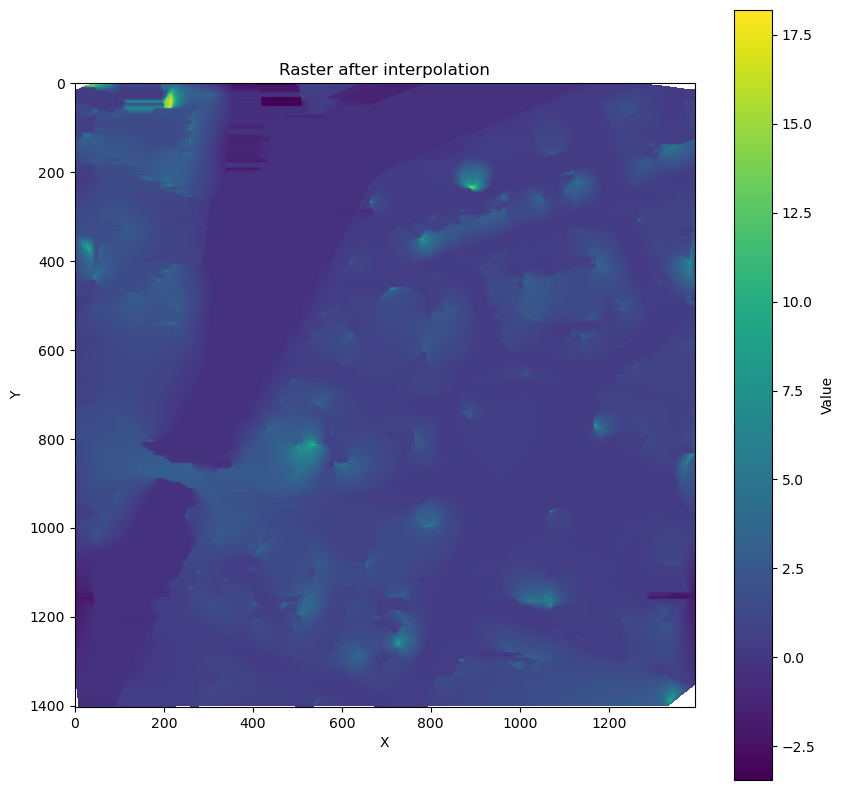

In [268]:
# Plot the combined raster
plt.figure(figsize=(10, 10))
plt.imshow(raster_array, cmap='viridis')
plt.title('Raster after interpolation')
plt.colorbar(label='Value')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

#### After 2 additional passes of minimum filter:

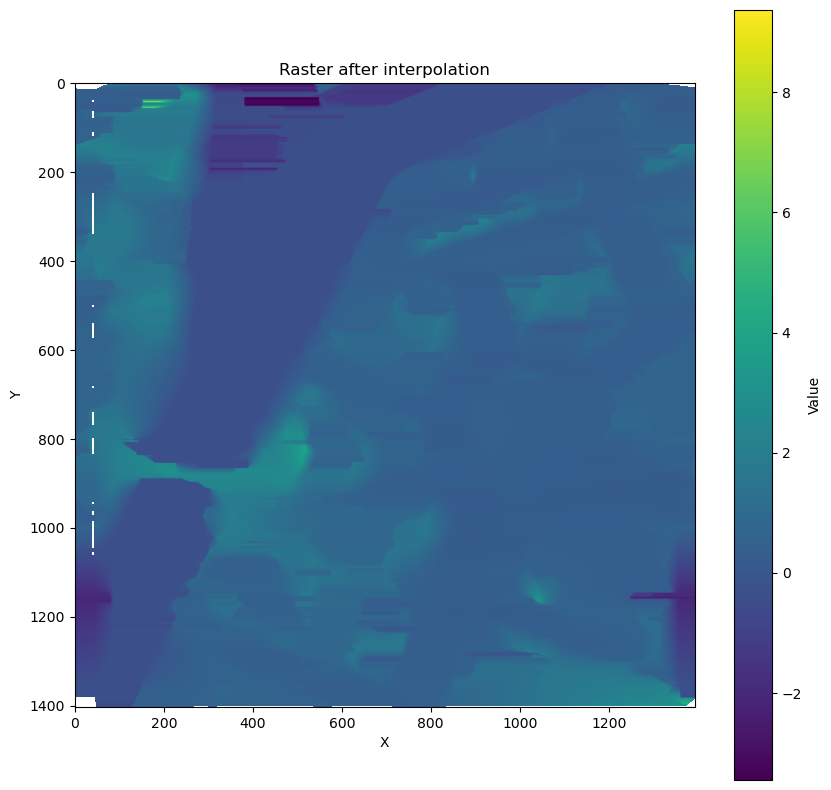

In [267]:
# Plot the combined raster
plt.figure(figsize=(10, 10))
plt.imshow(filtered_raster, cmap='viridis')
plt.title('Raster after interpolation')
plt.colorbar(label='Value')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

#### Get back the buildings:

In [ ]:
combined_building_mask = np.logical_or(bldg_mask, osm_bldg_mask).astype(np.uint8)

In [1]:
dsm_buildings = np.where(combined_building_mask == 0, filtered_raster, dsm)
# Write the raster array to a new file
output_raster = '../data/clean_data/canopydsm/dsm_buildings.tif'
with rasterio.open(output_raster, 'w', **meta) as dst:
    dst.write(dsm_buildings, 1)
# Plot the combined raster
plt.figure(figsize=(10, 10))
plt.imshow(dsm_buildings, cmap='viridis')
plt.title('Building DSM only')
plt.colorbar(label='Value')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

NameError: name 'np' is not defined

## Old

In [ ]:
# Read DSM
with rasterio.open('../data/clean_data/solar/12011952/12011952_p_6_2022_06_02_dsm.tif') as src:
    dsm = src.read(1)
    dsm_meta = src.meta.copy()

# Read canopy poly
trees = gpd.read_file('../../../TU Delft/Projects/lidR/25EZ1_21.gpkg')


# Rasterize tree polygons (same size as dsm so it works with UMEP)
tree_mask = rasterize(
    ((mapping(geom), 1) for geom in trees.geometry),
    out_shape=dsm.shape,
    transform=dsm_meta['transform'],
    fill=0,
    dtype='uint8'
)

# Create Canopy DSM
canopy_dsm = np.where(tree_mask == 1, dsm, np.nan)

# Save Canopy DSM
dsm_meta.update(dtype='float32', nodata=np.nan)
with rasterio.open('canopy_dsm.tif', 'w', **dsm_meta) as dst:
    dst.write(canopy_dsm, 1)

# Remove Trees from DSM (interpolation)
from scipy.ndimage import generic_filter

def interpolate(data):
    mask = np.isnan(data)
    data[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), data[~mask])
    return data

ground_dsm = generic_filter(canopy_dsm, interpolate, size=5, mode='nearest')

# Save Ground DSM
with rasterio.open('ground_dsm.tif', 'w', **dsm_meta) as dst:
    dst.write(ground_dsm, 1)


In [3]:
# Read DSM
with rasterio.open('../data/clean_data/solar/12011952/12011952_p_6_2022_06_02_dsm.tif') as src:
    dsm = src.read(1)
    dsm_meta = src.meta.copy()
    dsm_crs = src.crs

In [4]:
# Read DSM
with rasterio.open('../data/clean_data/solar/12011952/12011952_p_6_2022_06_02_dsm.tif') as src:
    dsm = src.read(1)
    dsm_meta = src.meta.copy()
    dsm_crs = src.crs
    # Read tree polygons
    trees = gpd.read_file('/Users/lbeuster/Documents/TU Delft/Projects/lidR/results/25EZ1_21.gpkg')
    trees_crs = trees.crs

    # Check and reproject if necessary
    if trees_crs != dsm_crs:
        trees = trees.to_crs(dsm_crs)


    trees.geometry = trees.buffer(0.5)

        # Mask DSM with tree polygons
    masked_dsm, _ = mask(src, trees.geometry, crop=True, filled=False)

NameError: name 'mask' is not defined

In [9]:
dsm_crs

CRS.from_epsg(32631)

In [4]:

# Read tree polygons
trees = gpd.read_file('/Users/lbeuster/Documents/TU Delft/Projects/lidR/results/25EZ1_21.gpkg')
trees_crs = trees.crs

# Check and reproject if necessary
if trees_crs != dsm_crs:
    trees = trees.to_crs(dsm_crs)


trees.geometry = trees.buffer(0.5)




In [9]:
trees.explore()

TODO: Trees need a buffer and maybe a union (even though that operation isn't necessary?)

In [6]:
# Rasterize tree polygons
tree_mask = rasterize(
    ((mapping(geom), 1) for geom in trees.geometry),
    out_shape=dsm.shape,
    transform=dsm_meta['transform'],
    fill=0,
    dtype='uint8'
)


What I was trying here was to see what input is needed for UMEP function. It seems like it doesn't like NAN values, but prefers 0 instead for nodata. Needs it for both the dsm as well as the canopy dsm. 

In [13]:

# Create Canopy DSM
canopy_dsm = np.where(tree_mask == 1, dsm, 0)

In [11]:
# Create Canopy DSM
canopy_dsm = np.where(tree_mask == 1, dsm, np.nan)

In [14]:
# Save Canopy DSM
dsm_meta.update(dtype='float32', nodata=np.nan)
with rasterio.open('../data/clean_data/canopydsm/canopy_dsm.tif', 'w', **dsm_meta) as dst:
    dst.write(canopy_dsm, 1)

In [20]:
# Remove Trees from DSM (interpolation)
from scipy.ndimage import generic_filter

In [24]:
# Interpolation function
def interpolate(data):
    mask = np.isnan(data)
    if mask.all():
        return np.nan  # Handle case where the window is all NaNs
    elif not mask.any():
        return np.mean(data)  # Handle case where the window is all valid values
    else:
        valid_data = data[~mask]
        invalid_data = data[mask]
        interp_values = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), valid_data)
        return np.nanmean(interp_values)

# Remove Trees from DSM (interpolation)
ground_dsm = generic_filter(dsm, interpolate, size=5, mode='nearest')

In [28]:
# Interpolation function
def interpolate(data):
    mask = np.isnan(data)
    if mask.all():
        return np.nan  # Handle case where the window is all NaNs
    elif not mask.any():
        return np.mean(data)  # Handle case where the window is all valid values
    else:
        # Only use ground values by excluding outliers (building heights)
        valid_data = data[~mask]
        valid_data = valid_data[valid_data < np.nanpercentile(data, 90)]
        if valid_data.size == 0:
            return np.nan
        return np.mean(valid_data)

# Remove Trees from DSM (interpolation)
ground_dsm = generic_filter(dsm, interpolate, size=15, mode='nearest')

In [29]:
# Save Ground DSM
with rasterio.open('../data/clean_data/canopydsm/ground_dsm.tif', 'w', **dsm_meta) as dst:
    dst.write(ground_dsm, 1)

In [30]:
from scipy.ndimage import minimum_filter

In [31]:
# Create a copy of the DSM to fill in tree areas
ground_dsm = np.copy(dsm)

# Define the size of the local window
window_size = 15  # Adjust this size based on your data resolution

# Compute the local minimum using a minimum filter
local_min = minimum_filter(dsm, size=window_size, mode='nearest')


# Replace tree pixels in the DSM with the local minimum
ground_dsm[tree_mask] = local_min[tree_mask]

# Save the resulting DSM without trees
dsm_meta.update(dtype='float32', nodata=np.nan)
with rasterio.open('../data/clean_data/canopydsm/ground_dsm.tif', 'w', **dsm_meta) as dst:
    dst.write(ground_dsm, 1)

In [ ]:
# Create Canopy DSM
ground_dsm = np.where(tree_mask != 1, dsm, np.nan)


In [9]:
# Create Canopy DSM
ground_dsm = np.where(tree_mask != 1, dsm, 0)


In [40]:
# Define the size of the local window
window_size = 50  # Adjust this size based on your data resolution

# Function to replace NaNs with local minimum
def fill_with_local_minimum(data):
    center_index = len(data) // 2
    if np.isnan(data[center_index]):
        return np.nanmin(data)
    else:
        return data[center_index]

# Apply the function to the ground_dsm to fill in NaNs with local minimum
filled_dsm = generic_filter(ground_dsm, fill_with_local_minimum, size=window_size, mode='nearest')

# Replace the original NaNs in ground_dsm with the values from filled_dsm
ground_dsm[np.isnan(ground_dsm)] = filled_dsm[np.isnan(ground_dsm)]

/var/folders/qg/ghhvk02j7t3f3b9th5d2412rxxy23f/T/ipykernel_37927/845014348.py:8: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(data)


In [10]:
# Save the resulting DSM without trees
dsm_meta.update(dtype='float32', nodata=np.nan)
with rasterio.open('../data/clean_data/canopydsm/ground_dsm.tif', 'w', **dsm_meta) as dst:
    dst.write(ground_dsm, 1)

In [43]:
from scipy.spatial import Delaunay
from scipy.interpolate import LinearNDInterpolator

In [60]:
# Get coordinates of non-tree pixels
rows, cols = np.where(~tree_mask)
points = np.column_stack((rows, cols))

# Interpolate using Delaunay triangulation
tri = Delaunay(points)
interpolator = LinearNDInterpolator(tri, ground_dsm[~tree_mask])

# Create meshgrid for whole DSM
all_rows, all_cols = np.indices(dsm.shape)
all_points = np.column_stack((all_rows.ravel(), all_cols.ravel()))

# Mask for nodata areas
nodata_mask = np.isnan(ground_dsm)

# Interpolate nodata values using the interpolator
ground_dsm[nodata_mask] = interpolator(all_points[nodata_mask])

# Ensure no negative values (optional step based on DSM characteristics)
ground_dsm[ground_dsm < 0] = 0

KeyboardInterrupt: 

In [51]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
import matplotlib.pyplot as plt


In [61]:
# Mask DSM with tree polygons
masked_dsm, _ = mask(src, trees.geometry, crop=True, filled=False)


RasterioIOError: Dataset is closed: ../data/clean_data/solar/12011952/12011952_p_6_2022_06_02_dsm.tif

In [57]:
dsm

array([[13.238157  , 13.241913  , 13.240485  , ..., 16.200573  ,
        16.207281  , 16.074492  ],
       [13.245048  , 13.248777  , 13.248334  , ..., 16.122526  ,
        15.708638  , 15.181873  ],
       [13.253944  , 13.256381  , 13.257053  , ..., 15.487819  ,
        13.826398  , 13.284081  ],
       ...,
       [ 0.49462113,  0.36046892, -0.06656245, ...,  0.5232695 ,
         0.51917964,  0.5190234 ],
       [ 0.4995078 ,  0.33632842, -0.15410125, ...,  0.5123671 ,
         0.51407814,  0.5257422 ],
       [ 0.49675155,  0.3318245 , -0.15537861, ...,  0.5103445 ,
         0.519032  ,  0.52425385]], dtype=float32)

In [ ]:
# Or visualize the filled DSM
plt.imshow(dsm_filled, cmap='terrain')
plt.colorbar()
plt.show()

In [ ]:
from scipy.interpolate import griddata

# Convert masked_dsm to a numpy array
dsm_array = masked_dsm[0]  # assuming masked_dsm is a masked array

# Create a grid of coordinates where NaNs need to be filled
y_nan, x_nan = np.where(np.isnan(dsm_array))
points = np.array([x_nan, y_nan]).T
values = dsm_array[~np.isnan(dsm_array)]

# Interpolate using nearest neighbor (you can choose other methods based on your preference)
dsm_filled = griddata(points, values, (x, y), method='nearest')